## Position Pipeline

In [ ]:
%reload_ext autoreload
%autoreload 2


This data pipeline takes the 2D position (in video pixels) of the green and red LEDs tracked by Trodes, and computes:
+ head position (in cm)
+ head orientation (in radians)
+ head velocity (in cm/s)
+ head speed (in cm/s)

We can then check the quality of the head position and direction by plotting the them on the video along with the oringal green and red LEDs.

This notebook will take you through this process for one dataset.

### 1. Loading the session data

First let us make sure that the session we want to analyze is inserted into the database:

In [2]:
import spyglass as nd

nwb_file_name = "chimi20200216_new.nwb"

nd.insert_sessions(nwb_file_name)

[2022-08-04 16:16:09,213][INFO]: Connecting zoldello@lmf-db.cin.ucsf.edu:3306
[2022-08-04 16:16:09,264][INFO]: Connected zoldello@lmf-db.cin.ucsf.edu:3306


/home/zoldello/anaconda3/envs/spyglass/lib/python3.9/site-packages/position_tools/core.py:3: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


After insert, a new nwb file is made that is a copy of the original version without the electrophysiological data. This name is used as a key in the downstream data analysis so we save the name of the copied version for later use.

In [3]:
from spyglass.common.nwb_helper_fn import get_nwb_copy_filename

nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)
nwb_copy_file_name

'chimi20200216_new_.nwb'

### 2. Setting the parameters for running the position pipeline

The parameters for the position pipeline are set by the `PositionInfoParameters` table. `default` is the name of the standard set of parameters. As usual, if you want to change the parameters, you can insert your own into the table.

The parameters are as follows:

+ `max_separation` is the maxmium acceptable distance (in cm) between the red and green LEDs. When the distance between the LEDs becomes greater than this number, the times are marked as NaNs and inferred by interpolation. This is useful parameter when the inferred red or green LED position tracks a reflection instead of the true red or green LED position. It is set to 9.0 cm by default.
+ `max_speed` is the maximum plausible speed (in cm/s) the animal can move at. Times when the speed is greater than this threshold are marked as NaNs and inferred by interpolation. This can be useful in preventing big, sudden jumps in position. It is set to 300.0 cm/s by default.
+ `position_smoothing_duration` controls how much the red and green LEDs are smoothed before computing the average of their position to get the head position. It is in units of seconds.
+ `speed_smoothing_std_dev` controls how much the head speed is smoothed. It corresponds to the standard deviation of the Gaussian kernel used to smooth the speed and is in units of seconds. It is set to 0.100 seconds by default.
+ `front_led1` is either 1 or 0 indicating True or False. It controls which LED is treated as the front LED and the back LED, which is important for calculating the head direction.
    + 1 indicates that the LED corresponding to `xloc`, `yloc` in the `RawPosition` table as the front LED and the LED corresponding to `xloc2`, `yloc2` as the back LED.
    + 0 indicates that `xloc`, `yloc` are treated as the back LED and `xloc2`, `yloc2` are treated as the front LED.

In [4]:
from spyglass.common.common_position import PositionInfoParameters

PositionInfoParameters()

*position_info max_separation max_speed     position_smoot speed_smoothin head_orient_sm led1_is_front  is_upsampled   upsampling_sam upsampling_int
+------------+ +------------+ +-----------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
default        9.0            300.0         0.125          0.1            0.001          1              0              nan            linear        
default_decodi 9.0            300.0         0.125          0.1            0.001          1              1              500.0          linear        
default_lfp    9.0            300.0         0.125          0.1            0.001          1              1              1000.0         linear        
 (Total: 3)

In [5]:
PositionInfoParameters.insert1(
    {"position_info_param_name": "default"}, skip_duplicates=True
)
PositionInfoParameters()

*position_info max_separation max_speed     position_smoot speed_smoothin head_orient_sm led1_is_front  is_upsampled   upsampling_sam upsampling_int
+------------+ +------------+ +-----------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
default        9.0            300.0         0.125          0.1            0.001          1              0              nan            linear        
default_decodi 9.0            300.0         0.125          0.1            0.001          1              1              500.0          linear        
default_lfp    9.0            300.0         0.125          0.1            0.001          1              1              1000.0         linear        
 (Total: 3)

Now that you have set the parameters, you need to associate those parameters with a partiuclar nwb file and interval using the `IntervalPositionInfoSelection` table in order to run the position pipeline.

Let's look at the intervals for `chimi20200216_new.nwb` first. We care about the intervals that start with `pos` and ending with `valid times`.

In [6]:
import pandas as pd

pd.DataFrame(nd.common.IntervalList & {"nwb_file_name": nwb_copy_file_name})

nwb_file_name  \
0    chimi20200216_new_.nwb   
1    chimi20200216_new_.nwb   
2    chimi20200216_new_.nwb   
3    chimi20200216_new_.nwb   
4    chimi20200216_new_.nwb   
..                      ...   
169  chimi20200216_new_.nwb   
170  chimi20200216_new_.nwb   
171  chimi20200216_new_.nwb   
172  chimi20200216_new_.nwb   
173  chimi20200216_new_.nwb   

                                    interval_list_name  \
0                                                01_s1   
1                                                02_r1   
2                            02_r1 noPrePostTrialTimes   
3                                                03_s2   
4                                                04_r2   
..                                                 ...   
169  R_fabb5ef8_ampl_2000_prop_75_artifact_removed_...   
170                                             sleeps   
171                    sleeps_runs_noPrePostTrialTimes   
172  sleeps_runs_noPrePostTrialTimes raw data valid...   
173  sleeps_runs_noPrePostTrialTimes raw data valid...   

                                           valid_times  
0            [[1581884110.9124804, 1581886102.599356]]  
1            [[1581886847.561317, 1581888227.5987928]]  
2           [[1581886896.4185014, 1581888227.5987928]]  
3           [[1581888339.9145422, 1581890273.3987277]]  
4            [[1581890568.8618634, 1581891934.598601]]  
..                                                 ...  
169         [[1581886896.4185073, 1581888227.5987911]]  
170  [[1581884110.9124804, 1581886102.599356], [158...  
171  [[1581884110.9124804, 1581886102.599356], [158...  
172  [[1581884110.9124804, 1581886102.599356], [158...  
173  [[1581884110.9134343, 1581886102.599356], [158...  

[174 rows x 3 columns]

Let's choose the interval corresponding to `pos 1 valid times` in `chimi20200216_new_.nwb`.

We first look at the "raw" position data now to see the input into the pipeline. The raw position is in the `RawPosition` table and corresponds to the inferred position of the red and green LEDs from the video (using an algorithm in Trodes). It is in units of pixels. The number of time points corresponds to when the position tracking was turned on and off (and so may not have the same number of time points as the video itself).

We can retrieve the data in the `RawPosition` table for a given interval using a special method called `fetch1_dataframe`. It returns the position of the red and green LEDs as a pandas dataframe where time is the index. The columns of the dataframe are:
+ `xloc`, `yloc` are the x- and y-position of one of the LEDs
+ `xloc2`, `yloc2` are the x- and y-position of the other LEDs.

In [7]:
from spyglass.common.common_behav import RawPosition

raw_position_df = (
    RawPosition()
    & {
        "nwb_file_name": nwb_copy_file_name,
        "interval_list_name": "pos 1 valid times",
    }
).fetch1_dataframe()
raw_position_df

[2022-08-04 16:16:12,541][WARNING]: Skipped checksum for file with hash: 050179d6-42a0-9236-45ee-6069346d0196, and path: /stelmo/nwb/raw/chimi20200216_new_.nwb


/stelmo/nwb/raw/chimi20200216_new_.nwb


xloc  yloc  xloc2  yloc2
time                                  
1.581887e+09   264   638    285    635
1.581887e+09   264   672    269    635
1.581887e+09   264   638    280    642
1.581887e+09   268   635    284    636
1.581887e+09   268   674    283    636
...            ...   ...    ...    ...
1.581888e+09   556   598    543    616
1.581888e+09   555   598    543    616
1.581888e+09   556   598    543    616
1.581888e+09   555   598    543    616
1.581888e+09   556   598    542    615

[39340 rows x 4 columns]

Let's just quickly plot the two LEDs to get a sense of the inputs to the pipeline:

Text(0.5, 1.0, 'Raw Position')

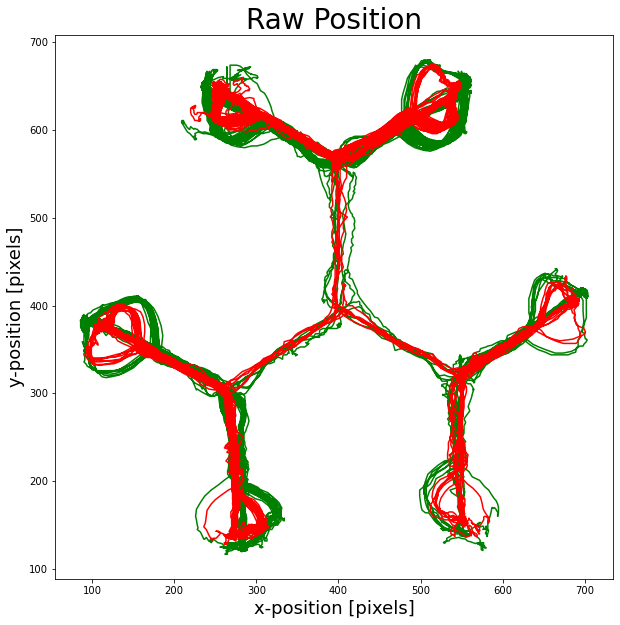

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(raw_position_df.xloc, raw_position_df.yloc, color="green")
ax.plot(raw_position_df.xloc2, raw_position_df.yloc2, color="red")
ax.set_xlabel("x-position [pixels]", fontsize=18)
ax.set_ylabel("y-position [pixels]", fontsize=18)
ax.set_title("Raw Position", fontsize=28)

Okay, now that we understand what the inputs to the pipeline are, let's associate a set of parameters with a given interval.

To associate parameters with a given interval, we insert them into the `IntervalPositionInfoSelection` table.

Here we associate the with the `default` position info parameters with the interval `pos 1 valid times`:

In [9]:
from spyglass.common.common_position import IntervalPositionInfoSelection

IntervalPositionInfoSelection.insert1(
    {
        "nwb_file_name": nwb_copy_file_name,
        "interval_list_name": "pos 1 valid times",
        "position_info_param_name": "default",
    },
    skip_duplicates=True,
)

Now let's check to see if we've inserted the parameters correctly:

In [10]:
IntervalPositionInfoSelection()

*position_info *nwb_file_name *interval_list
+------------+ +------------+ +------------+
default_decodi CH6120211203_. pos 0 valid ti
default_decodi CH6520211201_. pos 0 valid ti
default        chimi20200216_ pos 1 valid ti
default_decodi chimi20200216_ pos 1 valid ti
default_lfp    chimi20200216_ pos 1 valid ti
default        fern20211007_. pos 0 valid ti
default_decodi fern20211007_. pos 0 valid ti
default        fern20211007_. pos 1 valid ti
default_decodi fern20211007_. pos 1 valid ti
default        fern20211007_. pos 10 valid t
default_decodi fern20211007_. pos 10 valid t
default        fern20211007_. pos 11 valid t
   ...
 (Total: 1814)

### 3. Running the position pipeline and retrieving the results

Now that we have associated the parameters with the interval we want to run, we can finally run the pipeline for that interval.

We run the pipeline using the `populate` method on the `IntervalPositionInfo` table.

In [11]:
from spyglass.common.common_position import IntervalPositionInfo

IntervalPositionInfo.populate()

We can see that each NWB file, interval, and parameter set is now associated with a newly created analysis NWB file and object IDs that correspond to our newly computed data. This isn't as useful to work with so we will use another method below to actually retrieve the data for a given interval.

In [12]:
IntervalPositionInfo()

*position_info *nwb_file_name *interval_list analysis_file_ head_position_ head_orientati head_velocity_
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
default        chimi20200216_ pos 1 valid ti chimi20200216_ 92a087ca-3df6- 65199939-b878- a876e869-4eb5-
default        fern20211007_. pos 0 valid ti fern20211007_0 f4a20aa2-20a0- e835e832-86b0- d1e0ae3c-4c05-
default        fern20211007_. pos 1 valid ti fern20211007_G ae3317fa-bbd3- eedee7f8-290b- 86db909f-fb0d-
default        fern20211007_. pos 10 valid t fern20211007_I 8b7722cb-fa73- 74d5e5a8-d736- 7e67fbee-f766-
default        fern20211007_. pos 11 valid t fern20211007_5 c294ea11-10a8- a703e06b-b4f9- 228da90d-3442-
default        fern20211007_. pos 12 valid t fern20211007_Y e8b7017f-745e- db509824-cd50- 85064b3e-2cb7-
default        fern20211007_. pos 13 valid t fern20211007_0 62c1dbc6-8d03- 11734fa1-27c8- 919e565b-7937-
default        fern20211007_. pos 14 valid t fern20211007_E 93e1a36b-bd8a- f5796260-9bb1- 3bac5d8d-d103-
default        fern20211007_. pos 15 valid t fern20211007_B c0ead339-9380- 36c65b2e-a2db- d122d225-a1ba-
default        fern20211007_. pos 16 valid t fern20211007_W 71d010f3-9e46- 2c3542ee-18fb- 842bbba1-6e57-
default        fern20211007_. pos 17 valid t fern20211007_J d82418cf-98ca- 6e19cd2b-f134- e100713e-5cdb-
default        fern20211007_. pos 18 valid t fern20211007_6 edb09afb-62e1- 6c488035-0709- 9a0d60f8-60d4-
   ...
 (Total: 1814)

In order to retrieve the results of the computation, we use a special method called `fetch1_dataframe` from the `IntervalPositionInfo` table that will retrieve the position pipeline results as a pandas DataFrame. Time is set as the index of the dataframe.

This will only work for a single interval so we need to specify the NWB file and the interval.

This dataframe has the following columns:
+ `head_position_x`, `head_position_y`: the x,y position of the head position (in cm).
+ `head_orientation`: The direction of the head relative to the bottom left corner (in radians)
+ `head_velocity_x`, `head_velocity_y`: the directional change in head position over time (in cm/s)
+ `head_speed`: the magnitude of the change in head position over time (in cm/s)

In [13]:
position_info = (
    IntervalPositionInfo()
    & {
        "nwb_file_name": nwb_copy_file_name,
        "interval_list_name": "pos 1 valid times",
        "position_info_param_name": "default",
    }
).fetch1_dataframe()
position_info

/stelmo/nwb/analysis/chimi20200216_new_ZF24K2JHC1.nwb


head_position_x  head_position_y  head_orientation  \
time                                                               
1.581887e+09        91.051650       211.127050          2.999696   
1.581887e+09        90.844337       211.417287          3.078386   
1.581887e+09        90.637025       211.707525         -3.114572   
1.581887e+09        90.802875       211.596958         -3.033109   
1.581887e+09        91.288579       211.482443         -3.062550   
...                       ...              ...               ...   
1.581888e+09       182.158583       201.452467         -0.986926   
1.581888e+09       182.158583       201.397183         -0.978610   
1.581888e+09       182.213867       201.341900         -0.957589   
1.581888e+09       182.158583       201.341900         -0.970083   
1.581888e+09       182.158583       201.286617         -0.936414   

              head_velocity_x  head_velocity_y  head_speed  
time                                                        
1.581887e+09         1.387074         2.848838    3.168573  
1.581887e+09         3.123201         3.411111    4.624939  
1.581887e+09         5.431643         4.089597    6.799085  
1.581887e+09         8.097753         4.979262    9.506138  
1.581887e+09        10.840482         6.071373   12.424880  
...                       ...              ...         ...  
1.581888e+09         0.348276         0.218575    0.411182  
1.581888e+09         0.279135        -0.058413    0.285182  
1.581888e+09         0.193798        -0.283200    0.343162  
1.581888e+09         0.110838        -0.417380    0.431846  
1.581888e+09         0.045190        -0.453966    0.456209  

[39340 rows x 6 columns]

If you are not familiar with pandas, the time variable is set as the index. It can be accessed using `.index` on the dataframe.

In [14]:
position_info.index

Float64Index([1581886916.3153033, 1581886916.3486283, 1581886916.3819742,
              1581886916.4152992,  1581886916.448645, 1581886916.4819698,
              1581886916.5152948, 1581886916.5486405, 1581886916.5819652,
              1581886916.6152902,
              ...
              1581888227.3021932,  1581888227.335518,  1581888227.368864,
              1581888227.4021888,  1581888227.435535, 1581888227.4688597,
              1581888227.5021844, 1581888227.5355306, 1581888227.5688553,
                1581888227.60218],
             dtype='float64', name='time', length=39340)

### 4. Examining the results

We should always spot check our results to verify that the pipeline worked correctly.

#### Plots
Let's plot some of the variables first:

Text(0.5, 1.0, 'Head Position')

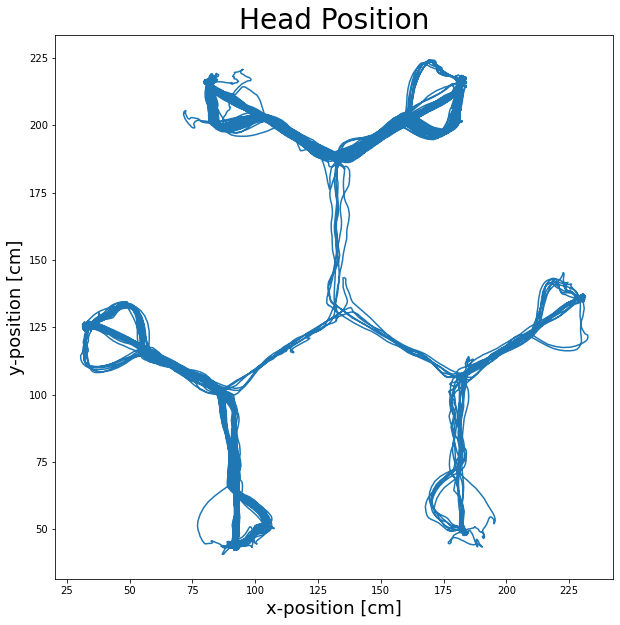

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(position_info.head_position_x, position_info.head_position_y)
ax.set_xlabel("x-position [cm]", fontsize=18)
ax.set_ylabel("y-position [cm]", fontsize=18)
ax.set_title("Head Position", fontsize=28)

Text(0.5, 1.0, 'Head Velocity')

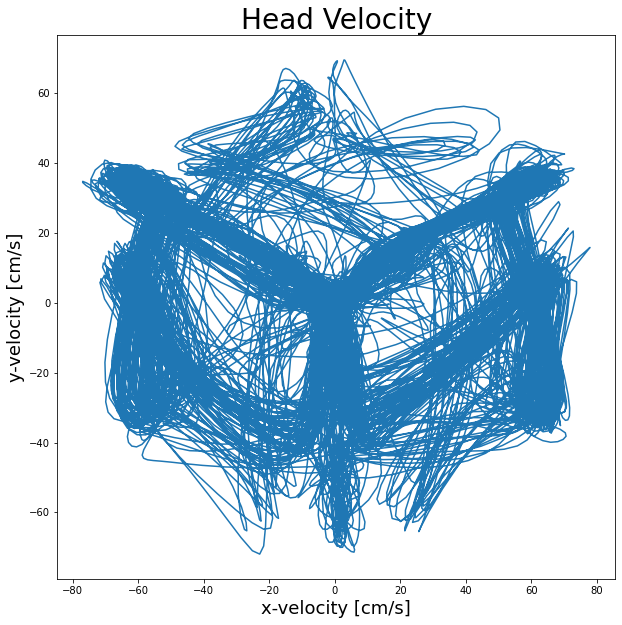

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(position_info.head_velocity_x, position_info.head_velocity_y)
ax.set_xlabel("x-velocity [cm/s]", fontsize=18)
ax.set_ylabel("y-velocity [cm/s]", fontsize=18)
ax.set_title("Head Velocity", fontsize=28)

(1581886916.3153033, 1581888227.60218)

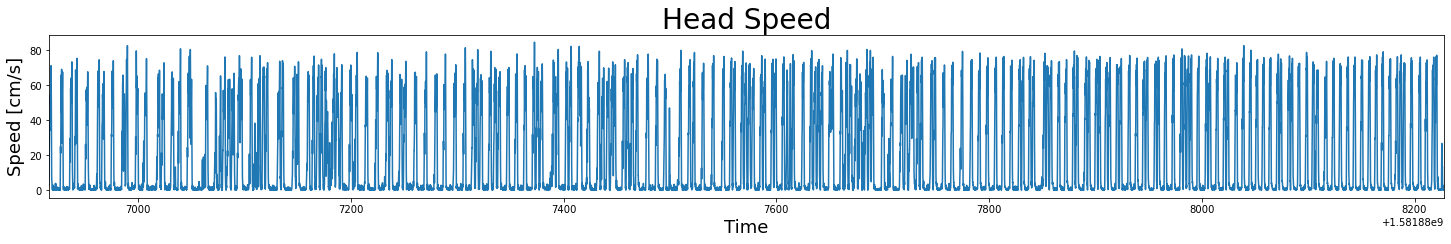

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(25, 3))
ax.plot(position_info.index, position_info.head_speed)
ax.set_xlabel("Time", fontsize=18)
ax.set_ylabel("Speed [cm/s]", fontsize=18)
ax.set_title("Head Speed", fontsize=28)
ax.set_xlim((position_info.index.min(), position_info.index.max()))

### Video

These look reasonable but it is better to evaluate these variables by plotting the results on the video where we can see how they correspond. 

The video will appear in the current working directory when it is done.

In [24]:
from spyglass.common.common_position import PositionVideo

PositionVideo().make(
    {
        "nwb_file_name": nwb_copy_file_name,
        "interval_list_name": "pos 1 valid times",
        "position_info_param_name": "default",
    }
)

[2022-08-04 15:05:53,003][WARNING]: Skipped checksum for file with hash: 050179d6-42a0-9236-45ee-6069346d0196, and path: /stelmo/nwb/raw/chimi20200216_new_.nwb


Loading position data...
Loading video data...


KeyError: '3234c1e5-c992-4fb4-9c82-d1603d90bce7'

### 4. Upsampling position data

Sometimes you need the position data to be in a different rate than it is sampled in, such as when decoding in 2 ms time bins. You can use the upsampling parameters to get this data:
+ `is_upsampled` controls whether upsampling happens. If it is 1 then there is upsampling, and if it is 0 then upsampling does not happen.
+ `upsampling_sampling_rate` is the rate you want to upsample to. For example position is typically recorded at 33 frames per seconds and you may want to upsample up to 500 frames per second.
+ `upsampling_interpolation_method` is the interpolation method used for upsampling. It is set to linear by default. See the methods available for pandas.DataFrame.interpolate to get a list of the methods.

In [25]:
PositionInfoParameters.insert1(
    {
        "position_info_param_name": "default_decoding",
        "is_upsampled": 1,
        "upsampling_sampling_rate": 500,
    },
    skip_duplicates=True,
)

PositionInfoParameters()

*position_info max_separation max_speed     position_smoot speed_smoothin head_orient_sm led1_is_front  is_upsampled   upsampling_sam upsampling_int
+------------+ +------------+ +-----------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
default        9.0            300.0         0.125          0.1            0.001          1              0              nan            linear        
default_decodi 9.0            300.0         0.125          0.1            0.001          1              1              500.0          linear        
default_lfp    9.0            300.0         0.125          0.1            0.001          1              1              1000.0         linear        
 (Total: 3)

In [26]:
IntervalPositionInfoSelection.insert1(
    {
        "nwb_file_name": nwb_copy_file_name,
        "interval_list_name": "pos 1 valid times",
        "position_info_param_name": "default_decoding",
    },
    skip_duplicates=True,
)

IntervalPositionInfoSelection()

*position_info *nwb_file_name *interval_list
+------------+ +------------+ +------------+
default_decodi CH6120211203_. pos 0 valid ti
default_decodi CH6520211125_. pos 0 valid ti
default_decodi CH6520211201_. pos 0 valid ti
default        chimi20200216_ pos 1 valid ti
default_decodi chimi20200216_ pos 1 valid ti
default_lfp    chimi20200216_ pos 1 valid ti
default        fern20211007_. pos 0 valid ti
default_decodi fern20211007_. pos 0 valid ti
default        fern20211007_. pos 1 valid ti
default_decodi fern20211007_. pos 1 valid ti
default        fern20211007_. pos 10 valid t
default_decodi fern20211007_. pos 10 valid t
   ...
 (Total: 1815)

In [27]:
IntervalPositionInfo.populate()

In [28]:
upsampled_position_info = (
    IntervalPositionInfo()
    & {
        "nwb_file_name": nwb_copy_file_name,
        "interval_list_name": "pos 1 valid times",
        "position_info_param_name": "default_decoding",
    }
).fetch1_dataframe()

upsampled_position_info

/stelmo/nwb/analysis/chimi20200216_new_6YC9LPAR7S.nwb


head_position_x  head_position_y  head_orientation  \
time                                                               
1.581887e+09        91.051650       211.127050          2.680048   
1.581887e+09        91.039455       211.144123          3.003241   
1.581887e+09        91.027260       211.161196          3.008398   
1.581887e+09        91.015065       211.178268          3.012802   
1.581887e+09        91.002871       211.195341          3.017242   
...                       ...              ...               ...   
1.581888e+09       182.158583       201.299625         -0.944304   
1.581888e+09       182.158583       201.296373         -0.942329   
1.581888e+09       182.158583       201.293121         -0.940357   
1.581888e+09       182.158583       201.289869         -0.953059   
1.581888e+09       182.158583       201.286617         -0.588081   

              head_velocity_x  head_velocity_y  head_speed  
time                                                        
1.581887e+09         1.741550         2.301478    2.886139  
1.581887e+09         1.827555         2.333931    2.964320  
1.581887e+09         1.915800         2.366668    3.044898  
1.581887e+09         2.006286         2.399705    3.127901  
1.581887e+09         2.099012         2.433059    3.213352  
...                       ...              ...         ...  
1.581888e+09         0.057520        -0.356012    0.360629  
1.581888e+09         0.053954        -0.356343    0.360404  
1.581888e+09         0.050477        -0.356407    0.359964  
1.581888e+09         0.047091        -0.356212    0.359312  
1.581888e+09         0.043796        -0.355764    0.358450  

[655645 rows x 6 columns]

Text(0.5, 1.0, 'Upsampled Head Position')

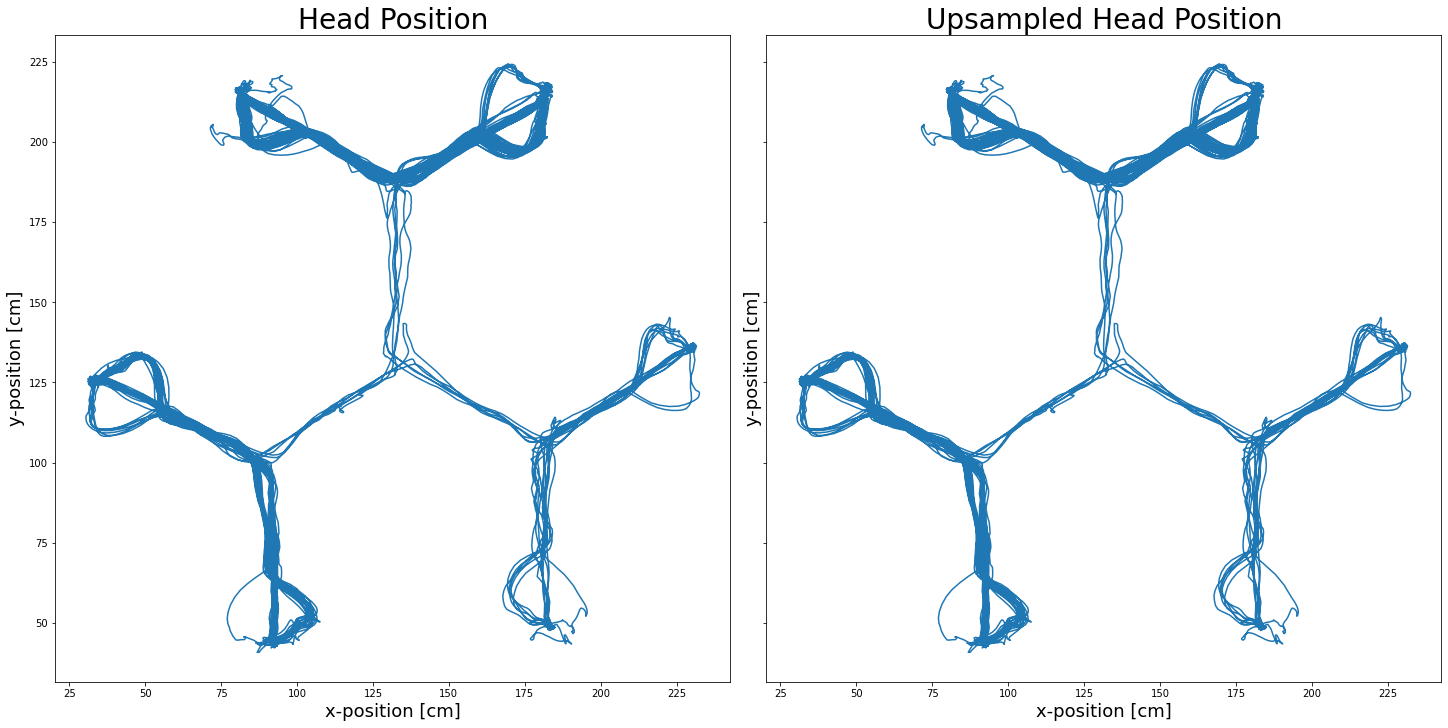

In [24]:
fig, axes = plt.subplots(
    1, 2, figsize=(20, 10), sharex=True, sharey=True, constrained_layout=True
)
axes[0].plot(position_info.head_position_x, position_info.head_position_y)
axes[0].set_xlabel("x-position [cm]", fontsize=18)
axes[0].set_ylabel("y-position [cm]", fontsize=18)
axes[0].set_title("Head Position", fontsize=28)

axes[1].plot(
    upsampled_position_info.head_position_x,
    upsampled_position_info.head_position_y,
)
axes[1].set_xlabel("x-position [cm]", fontsize=18)
axes[1].set_ylabel("y-position [cm]", fontsize=18)
axes[1].set_title("Upsampled Head Position", fontsize=28)

Text(0.5, 1.0, 'Upsampled Head Speed')

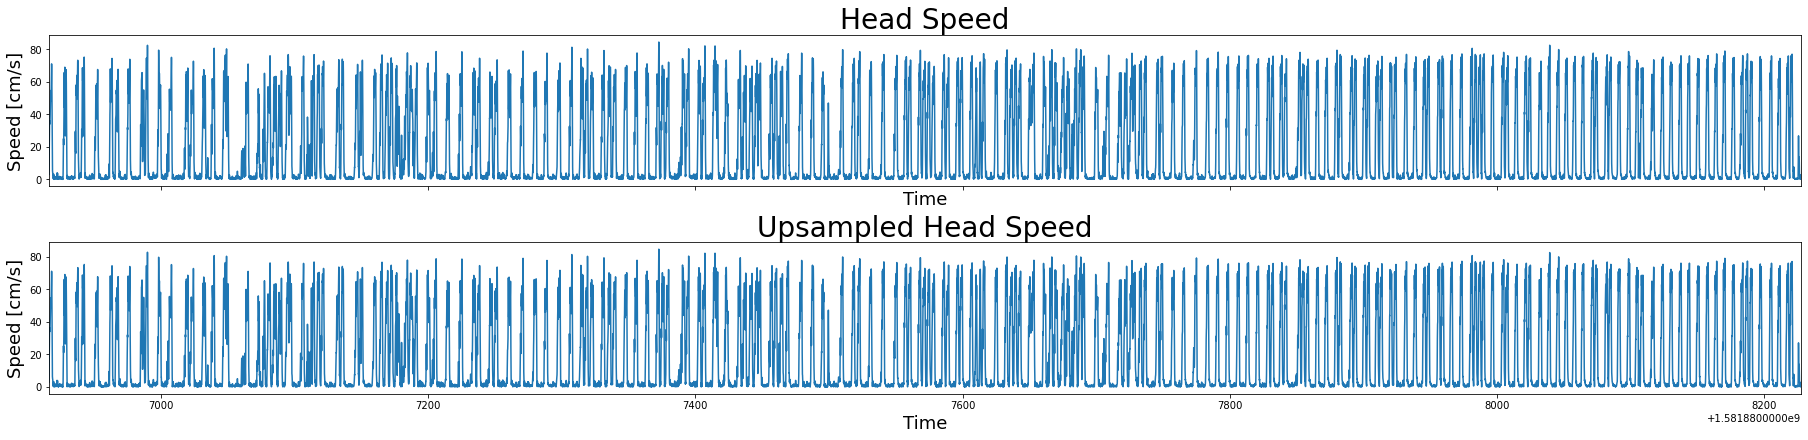

In [25]:
fig, axes = plt.subplots(
    2, 1, figsize=(25, 6), sharex=True, sharey=True, constrained_layout=True
)
axes[0].plot(position_info.index, position_info.head_speed)
axes[0].set_xlabel("Time", fontsize=18)
axes[0].set_ylabel("Speed [cm/s]", fontsize=18)
axes[0].set_title("Head Speed", fontsize=28)
axes[0].set_xlim((position_info.index.min(), position_info.index.max()))

axes[1].plot(upsampled_position_info.index, upsampled_position_info.head_speed)
axes[1].set_xlabel("Time", fontsize=18)
axes[1].set_ylabel("Speed [cm/s]", fontsize=18)
axes[1].set_title("Upsampled Head Speed", fontsize=28)

Text(0.5, 1.0, 'Upsampled Head Velocity')

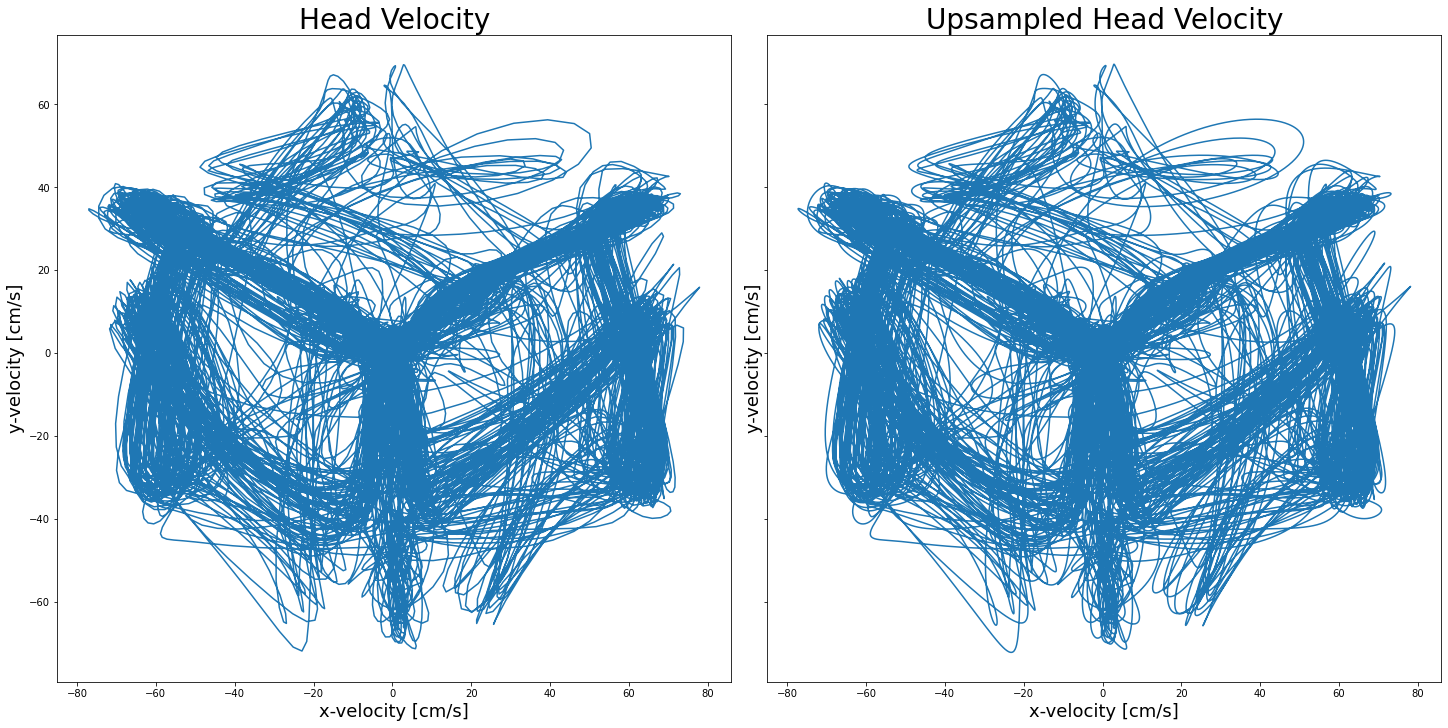

In [26]:
fig, axes = plt.subplots(
    1, 2, figsize=(20, 10), sharex=True, sharey=True, constrained_layout=True
)
axes[0].plot(position_info.head_velocity_x, position_info.head_velocity_y)
axes[0].set_xlabel("x-velocity [cm/s]", fontsize=18)
axes[0].set_ylabel("y-velocity [cm/s]", fontsize=18)
axes[0].set_title("Head Velocity", fontsize=28)

axes[1].plot(
    upsampled_position_info.head_velocity_x,
    upsampled_position_info.head_velocity_y,
)
axes[1].set_xlabel("x-velocity [cm/s]", fontsize=18)
axes[1].set_ylabel("y-velocity [cm/s]", fontsize=18)
axes[1].set_title("Upsampled Head Velocity", fontsize=28)